In [1]:
import os
from typing import Optional
from datetime import datetime

import numpy as np
import pandas as pd
import geopandas as gpd

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from shapely.geometry import Point, Polygon
import xyzservices.providers as xyz
import contextily as ctx

In [2]:
DEFAULT_BIKESHARE_FILE = "processed_gbfs_data/bikeshare_2025-02-28_15-44-09.geojson"
SEATTLE_GEOJSON_URL = "https://raw.githubusercontent.com/seattleflu/seattle-geojson/master/seattle_geojsons/2016_seattle_city.geojson"
NEIGHBORHOOD_BOUNDARIES_URL = "https://raw.githubusercontent.com/seattleio/seattle-boundaries-data/refs/heads/master/data/neighborhoods.geojson"


def load_seattle_boundary(url: str) -> gpd.GeoDataFrame:
    """
    Load seattle boundary as a geopandas dataframe.

    :param url: URL to Seattle boundary GeoJSON file

    :return: GeoDataFrame of Seattle boundary
    """
    seattle_gdf = gpd.read_file(url, engine='pyogrio')
    seattle_gdf.to_crs("EPSG:32610", inplace=True)

    return seattle_gdf


def load_neighborhoods(
    url: str,
    seattle_gdf: gpd.GeoDataFrame
) -> gpd.GeoDataFrame:
    """
    Load Seattle neighborhoods geopandas dataframe.

    :param url: URL to Seattle neighborhoods GeoJSON file
    :param seattle_gdf: GeoDataFrame of Seattle boundary

    :return: GeoDataFrame of Seattle neighborhoods
    """
    seattle_neighborhoods_gdf = gpd.read_file(url, engine='pyogrio')
    seattle_neighborhoods_gdf.to_crs("EPSG:32610", inplace=True)

    seattle_neighborhoods_gdf = seattle_neighborhoods_gdf.clip(seattle_gdf)
    
    return seattle_neighborhoods_gdf


def dissolve_neighborhoods(
    seattle_neighborhoods_gdf: gpd.GeoDataFrame
) -> gpd.GeoDataFrame:
    """
    Group nested neighborhoods into single nieghborhood polygons

    :param seattle_neighborhoods_gdf: GeoDataFrame of Seattle neighborhoods

    :return: Dissolved GeoDataFrame of Seattle neighborhoods
    """
    return seattle_neighborhoods_gdf[["nhood", "area", "geometry"]].dissolve(by="nhood", aggfunc="sum")


def filter_bikeshare_system_by_nhood(
    bikeshare_gdf: gpd.GeoDataFrame,
    nhood_gdf: gpd.GeoDataFrame,
    neighborhood: Optional[str] = None
) -> tuple[gpd.GeoDataFrame, gpd.GeoDataFrame]:
    """
    Filter bikeshare system by neighborhood

    :param bikeshare_gdf: GeoDataFrame of bikeshare system data
    :param nhood_gdf: GeoDataFrame of Seattle neighborhoods
    :param neighborhood: Name of neighborhood to focus on

    :return: Tuple of filtered bikeshare GeoDataFrame and neighborhood GeoDataFrame
    """
    if neighborhood:
        if neighborhood not in nhood_gdf.index:
            raise ValueError(f"Neighborhood '{neighborhood}' not found in Seattle. Must be one of {nhood_gdf.index}.")
        else:
            nhood_sub_gdf = nhood_gdf[nhood_gdf.index == neighborhood]
    else:
        nhood_sub_gdf = nhood_gdf

    return bikeshare_gdf.clip(nhood_sub_gdf), nhood_sub_gdf


def filter_bikeshare_system_by_start_date(
    gdf: gpd.GeoDataFrame,
    start_date: datetime,
    num_days: int
) -> gpd.GeoDataFrame:
    """
    Filter bikshare system by date
    
    :param gdf: GeoDataFrame of bikeshare system data
    :param start_date: Start date for filtering
    :param num_days: Number of days to filter
    
    :return: Filtered GeoDataFrame
    """
    end_time = start_date + pd.Timedelta(days=num_days)
    mask = (gdf.datetime >= start_date) & (gdf.datetime < end_time)

    return gdf.loc[mask]

In [3]:
bikeshare_gdf = gpd.read_file(os.path.join("..", DEFAULT_BIKESHARE_FILE), engine='pyogrio')
bikeshare_gdf.crs

<Projected CRS: EPSG:32610>
Name: WGS 84 / UTM zone 10N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 126°W and 120°W, northern hemisphere between equator and 84°N, onshore and offshore. Canada - British Columbia (BC); Northwest Territories (NWT); Nunavut; Yukon. United States (USA) - Alaska (AK).
- bounds: (-126.0, 0.0, -120.0, 84.0)
Coordinate Operation:
- name: UTM zone 10N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
date = '2025-02-22'
num_days = 1
neighborhood = None

In [5]:
seattle_gdf = load_seattle_boundary(url=SEATTLE_GEOJSON_URL)
seattle_neighborhoods_gdf = load_neighborhoods(url=NEIGHBORHOOD_BOUNDARIES_URL, seattle_gdf=seattle_gdf)
seattle_neighborhoods_dissolved_gdf = dissolve_neighborhoods(seattle_neighborhoods_gdf)
bikeshare_sub_gdf = filter_bikeshare_system_by_start_date(
    gdf=bikeshare_gdf, start_date=datetime.strptime(date, "%Y-%m-%d"), num_days=num_days
)
bikeshare_sub_gdf, nhood_sub_gdf = filter_bikeshare_system_by_nhood(
    bikeshare_gdf=bikeshare_sub_gdf,
    nhood_gdf=seattle_neighborhoods_dissolved_gdf,
    neighborhood=neighborhood,
)

In [6]:
bikeshare_sub_gdf

,bike_id,lat,lon,is_reserved,is_disabled,current_range_meters,vehicle_type_id,last_reported,vehicle_type,datetime,geometry
1756467,abd76f21-9849-4273-bb50-9a8db8b6b77b,47.510611,-122.260365,False,False,36057,3,1740295787,e-bike,2025-02-22 23:30:19,POINT (555693.091 5262174.083)
1966782,861a5cf6-9dff-4ded-a507-3b1881ff57c6,47.510622,-122.260362,False,False,35516,3,1740292211,e-bike,2025-02-22 22:30:17,POINT (555693.305 5262175.307)
581519,8bd36a87-01c3-41fa-bacf-b933c369d5f3,47.510622,-122.260362,False,False,35516,3,1740294034,e-bike,2025-02-22 23:00:18,POINT (555693.305 5262175.307)
628622,5a4cbb4c-3c21-4e85-9aed-a460e583a822,47.510629,-122.260376,False,False,36057,3,1740290411,e-bike,2025-02-22 22:00:16,POINT (555692.243 5262176.075)
2255887,867042e0-474f-4e3c-a42a-3b6772388655,47.510629,-122.260376,False,False,36057,3,1740288599,e-bike,2025-02-22 21:30:15,POINT (555692.243 5262176.075)
...,...,...,...,...,...,...,...,...,...,...,...
631509,2af9764a-fd82-4afc-b212-65a1fc2b21de,47.733795,-122.312681,False,False,28299,2,1740290413,scooter,2025-02-22 22:00:16,POINT (551533.998 5286942.082)
973924,7bf3f966-c5b6-4412-9fc8-a283632c1a6c,47.733796,-122.312689,False,False,28299,2,1740279592,scooter,2025-02-22 19:00:12,POINT (551533.397 5286942.188)
2088517,aac8da3a-b1bf-427d-92b1-db3a1402f843,47.733796,-122.312689,False,False,28299,2,1740281378,scooter,2025-02-22 19:30:12,POINT (551533.397 5286942.188)
720185,3260e05a-d282-448c-bacc-cf50058578d4,47.733800,-122.312647,False,False,28299,2,1740270599,scooter,2025-02-22 16:30:06,POINT (551536.542 5286942.66)


In [7]:
# seattle_neighborhoods_gdf.explore()

In [8]:
bikeshare_sub_coords = bikeshare_sub_gdf.geometry.get_coordinates()

bikeshare_sub_with_coords_gdf = bikeshare_sub_gdf.merge(
    bikeshare_sub_coords,
    left_index=True,
    right_index=True,
    how='inner',
)

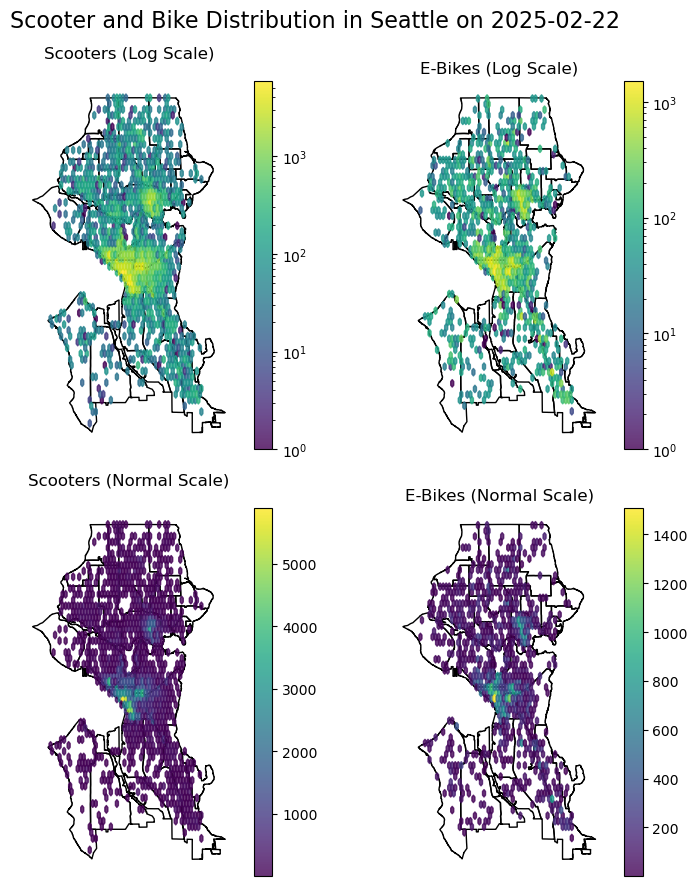

In [9]:
scooters = bikeshare_sub_with_coords_gdf[bikeshare_sub_with_coords_gdf.vehicle_type == "scooter"]
bikes = bikeshare_sub_with_coords_gdf[bikeshare_sub_with_coords_gdf.vehicle_type == "e-bike"]

fig, axs = plt.subplots(2, 2, figsize=(8, 9), sharex=True, sharey=True)

for ax in axs.flat:
    nhood_sub_gdf.plot(ax=ax,  facecolor="None", edgecolor='black')
    ax.axis("off")

scooters.plot.hexbin(
    "x",
    "y",
    ax=axs[0, 0],
    norm=colors.LogNorm(),
    gridsize=(50,28),
    alpha=.8,
    cmap="viridis",
    mincnt=1,
    title="Scooters (Log Scale)",
    legend=False,
)

bikes.plot.hexbin(
    "x",
    "y",
    ax=axs[0, 1],
    norm=colors.LogNorm(),
    gridsize=(50,28),
    alpha=.8,
    cmap="viridis",
    mincnt=1,
    title="E-Bikes (Log Scale)"
)

scooters.plot.hexbin(
    "x",
    "y",
    ax=axs[1, 0],
    gridsize=(50,28),
    alpha=.8,
    cmap="viridis",
    mincnt=1,
    title="Scooters (Normal Scale)"
)
bikes.plot.hexbin(
    "x",
    "y",
    ax=axs[1, 1],
    gridsize=(50,28),
    alpha=.8,
    cmap="viridis",
    mincnt=1,
    title="E-Bikes (Normal Scale)"
)

plt.tight_layout()
plt.suptitle(f"Scooter and Bike Distribution in Seattle on {date}", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.savefig(f"../visuals/scooter_bike_hexbin_{date.replace('-', '_')}.png")
plt.show()

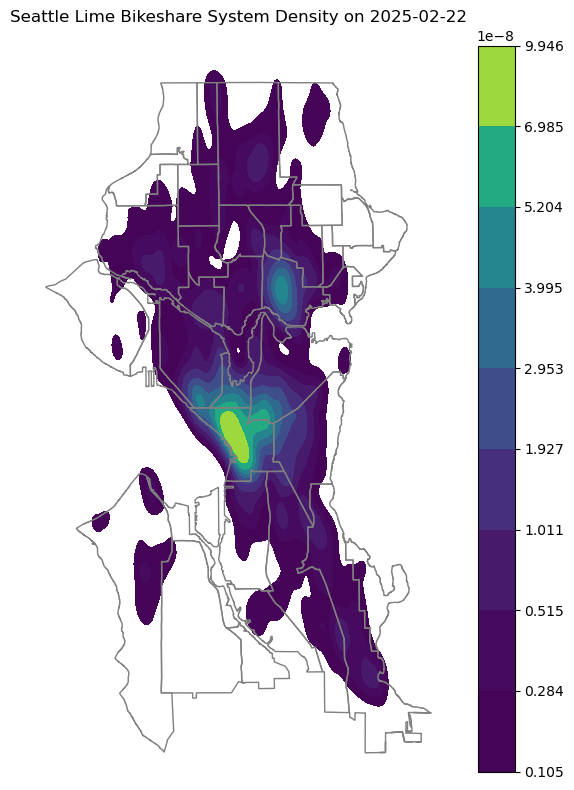

In [12]:
# STUDENT CODE HERE
fig = plt.figure(figsize=(6,8), dpi=100)
ax = fig.add_subplot(111)

sns.kdeplot(
    data=bikeshare_sub_with_coords_gdf,
    x=bikeshare_sub_with_coords_gdf['x'],
    y=bikeshare_sub_with_coords_gdf['y'],
    ax=ax,
    cmap="viridis",
    fill=True,
    cbar=True,
)
nhood_sub_gdf.plot(ax=ax, edgecolor='grey', facecolor="None")
ax.axis("off")
# ax.set_xlim(xlim_left, xlim_right)
# ax.set_ylim(ylim_bottom, ylim_top)
ax.set_title(f"Seattle Lime Bikeshare System Density on {date}")
plt.subplots_adjust(top=0.9)
plt.tight_layout()
plt.savefig(f"../visuals/lime_bike_density_all_day_{date.replace("-", "_")}.png")
plt.show()

In [ ]:
# # STUDENT CODE HERE
# fig = plt.figure(figsize=(15,6))
# ax = fig.add_subplot(111)

# states_gdf_aea_with_agg_data.plot(ax=ax, column="count", cmap="inferno", legend=True)
# ax.set_title("Number of Power Plants by State")
# plt.show()

In [3]:
bikeshare_gdf = gpd.read_file(os.path.join("..", DEFAULT_BIKESHARE_FILE), engine='pyogrio')
date = '2025-02-22'
num_days = 1

In [4]:
def add_coords_as_column(gdf: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    """
    """
    sub_coords = gdf.geometry.get_coordinates()

    with_coords_gdf = gdf.merge(
        sub_coords,
        left_index=True,
        right_index=True,
        how='inner',
    )
    return with_coords_gdf


def plot_hexbins(
    bikeshare_gdf: gpd.GeoDataFrame,
    nhood_sub_gdf: gpd.GeoDataFrame,
    neighborhood: str,
    date: str,
    save: bool = False
) -> None:
    """
    
    """
    scooters = bikeshare_gdf[bikeshare_gdf.vehicle_type == "scooter"]
    bikes = bikeshare_gdf[bikeshare_gdf.vehicle_type == "e-bike"]

    if neighborhood:
        gridsize = (30, 14)
    else:
        gridsize = (50, 28)

    fig, axs = plt.subplots(2, 2, figsize=(8, 9), sharex=True, sharey=True)

    for ax in axs.flat:
        nhood_sub_gdf.plot(ax=ax,  facecolor="None", edgecolor='black')
        ax.axis("off")

    alpha = .5

    scooters.plot.hexbin(
        "x",
        "y",
        ax=axs[0, 0],
        norm=colors.LogNorm(),
        gridsize=gridsize,
        alpha=alpha,
        cmap="viridis",
        mincnt=1,
        title="Scooters (Log Scale)",
        legend=False,
    )

    bikes.plot.hexbin(
        "x",
        "y",
        ax=axs[0, 1],
        norm=colors.LogNorm(),
        gridsize=gridsize,
        alpha=alpha,
        cmap="viridis",
        mincnt=1,
        title="E-Bikes (Log Scale)"
    )

    scooters.plot.hexbin(
        "x",
        "y",
        ax=axs[1, 0],
        gridsize=gridsize,
        alpha=alpha,
        cmap="viridis",
        mincnt=1,
        title="Scooters (Normal Scale)"
    )
    bikes.plot.hexbin(
        "x",
        "y",
        ax=axs[1, 1],
        gridsize=gridsize,
        alpha=alpha,
        cmap="viridis",
        mincnt=1,
        title="E-Bikes (Normal Scale)"
    )

    plt.tight_layout()
    plt.suptitle(f"Scooter and Bike Distribution in Seattle on {date}{f':\n{neighborhood}' if neighborhood else ''}", fontsize=16)
    plt.subplots_adjust(top=0.9)

    if neighborhood:
        for ax in axs.flat:
            # ctx.add_basemap(ax, crs=bikeshare_gdf.crs, source=ctx.providers.CartoDB.VoyagerNoLabels, attribution=False)
            ctx.add_basemap(ax, crs=bikeshare_gdf.crs, source=ctx.providers.CartoDB.Positron, attribution=False)

    if save:
        plt.savefig(f"../visuals/scooter_bike_hexbin_in_{neighborhood}_{date.replace('-', '_')}.png")
    else:
        plt.show()


def plot_kde(
    gdf: gpd.GeoDataFrame,
    nhood_sub_gdf: gpd.GeoDataFrame,
    neighborhood: str,
    date: str,
    save: bool = False,
) -> None:
    # STUDENT CODE HERE
    fig = plt.figure(figsize=(6,8), dpi=100)
    ax = fig.add_subplot(111)

    sns.kdeplot(
        data=gdf,
        x=gdf['x'],
        y=gdf['y'],
        ax=ax,
        cmap="viridis",
        fill=True,
        cbar=True,
        alpha=0.5
    )
    nhood_sub_gdf.plot(ax=ax, edgecolor='grey', facecolor="None")
    ctx.add_basemap(ax, crs=bikeshare_gdf.crs, source=ctx.providers.CartoDB.Positron, attribution=False)
    ax.axis("off")
    # ax.set_xlim(xlim_left, xlim_right)
    # ax.set_ylim(ylim_bottom, ylim_top)
    ax.set_title(f"Seattle Lime Bikeshare System Density on {date}{f':\n{neighborhood}' if neighborhood else ''}")
    plt.subplots_adjust(top=0.9)
    plt.tight_layout()

    if save:
        plt.savefig(f"../visuals/lime_bike_in_{neighborhood}_density_all_day_{date.replace("-", "_")}.png")
    else:
        plt.show()


def plot_bikeshare_heatmaps(
    bikeshare_gdf: gpd.GeoDataFrame,
    date: str,
    num_days: int,
    neighborhood: Optional[str] = None,
    save: bool = True
) -> None:
    seattle_gdf = load_seattle_boundary(url=SEATTLE_GEOJSON_URL)
    seattle_neighborhoods_gdf = load_neighborhoods(url=NEIGHBORHOOD_BOUNDARIES_URL, seattle_gdf=seattle_gdf)
    seattle_neighborhoods_dissolved_gdf = dissolve_neighborhoods(seattle_neighborhoods_gdf)
    bikeshare_sub_gdf = filter_bikeshare_system_by_start_date(
        gdf=bikeshare_gdf, start_date=datetime.strptime(date, "%Y-%m-%d"), num_days=num_days
    )
    bikeshare_sub_gdf, nhood_sub_gdf = filter_bikeshare_system_by_nhood(
        bikeshare_gdf=bikeshare_sub_gdf,
        nhood_gdf=seattle_neighborhoods_dissolved_gdf,
        neighborhood=neighborhood,
    )

    bikeshare_sub_with_coords_gdf = add_coords_as_column(bikeshare_sub_gdf)

    plot_hexbins(
        bikeshare_sub_with_coords_gdf,
        nhood_sub_gdf,
        neighborhood,
        date,
        save=save,
    )
    plot_kde(
        bikeshare_sub_with_coords_gdf,
        nhood_sub_gdf,
        neighborhood,
        date,
        save=save
    )

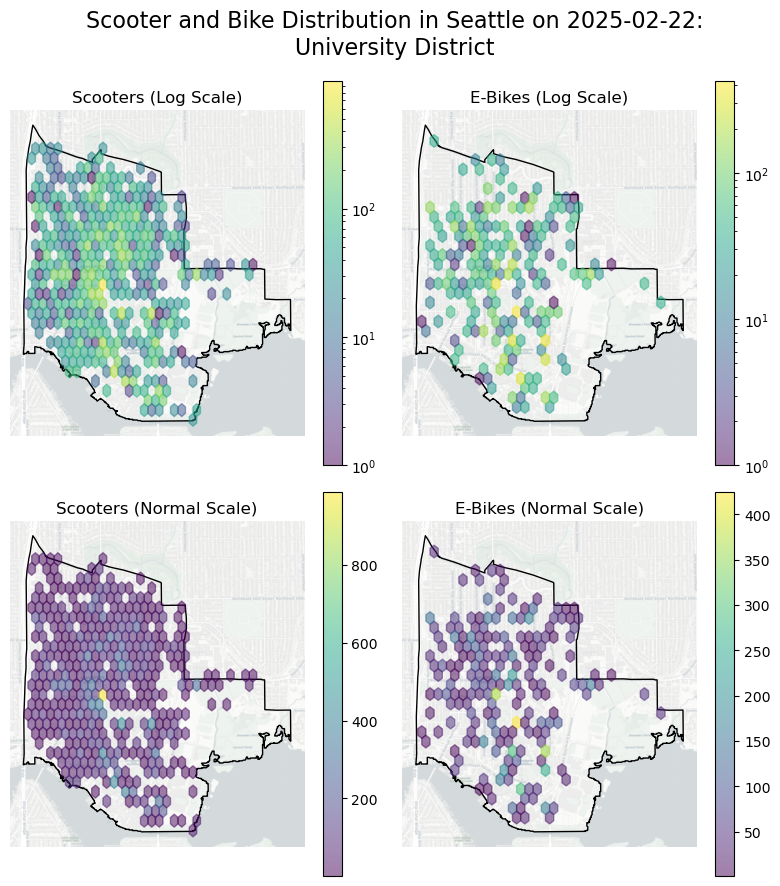

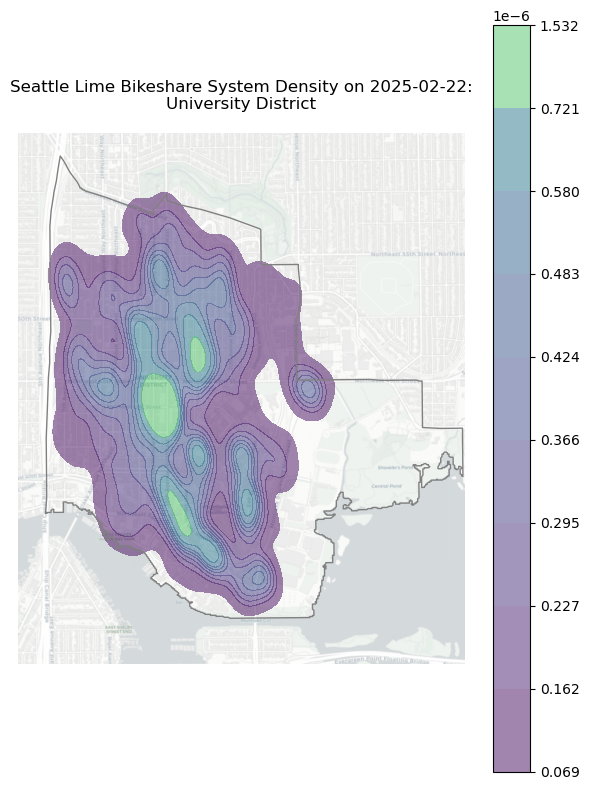

In [7]:
plot_bikeshare_heatmaps(bikeshare_gdf, date, num_days, "University District", save=True)

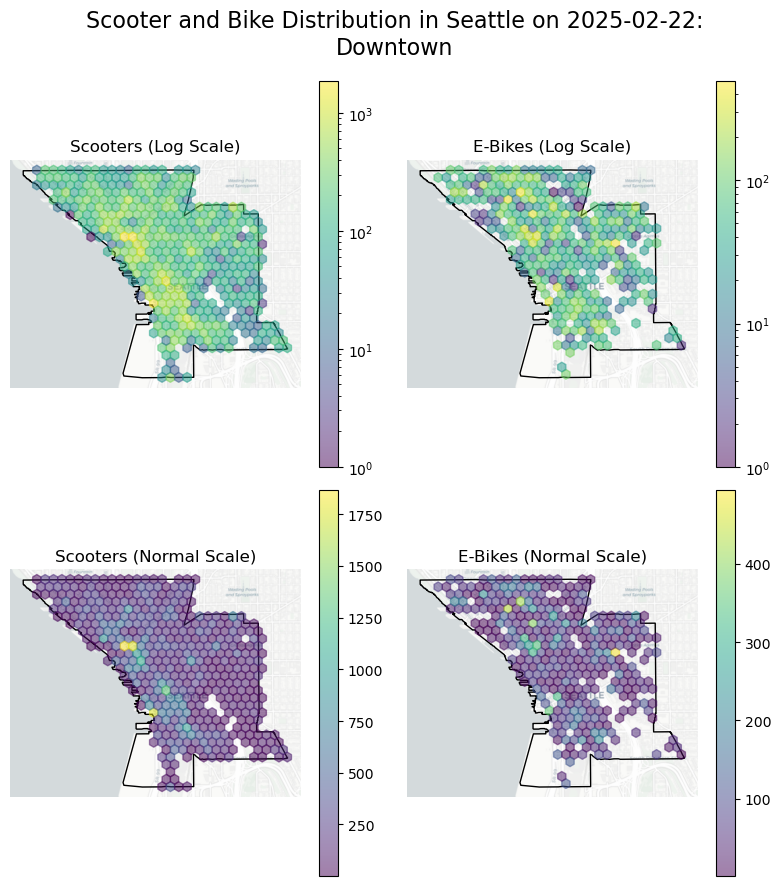

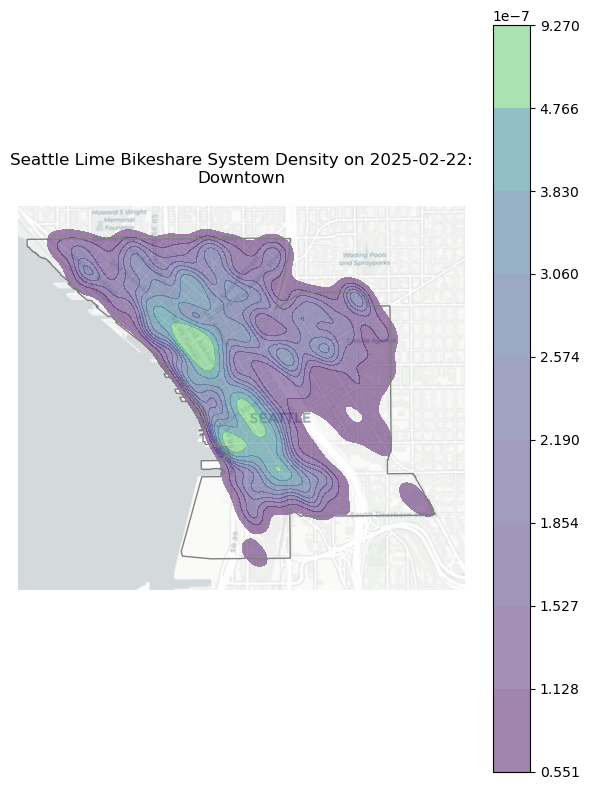

In [8]:
plot_bikeshare_heatmaps(bikeshare_gdf, date, num_days, "Downtown", save=True)